In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, io
import torch.backends.cudnn as cudnn
from tqdm import tqdm  # ✅ Thêm tqdm

# ===============================================================
# Dataset – preload toàn bộ ảnh vào RAM, ép RGB + tqdm progress
# ===============================================================
class FERDatasetPreload(Dataset):
    def __init__(self, root_dir, categories, train=True):
        self.train = train
        self.data, self.labels = [], []
        self.categories = categories

        print(f"📂 Loading images from {root_dir} ...")
        for i, cls in enumerate(categories):
            folder = os.path.join(root_dir, cls)
            file_list = [fn for fn in os.listdir(folder) if fn.lower().endswith(('.jpg', '.png', '.jpeg'))]
            for fn in tqdm(file_list, desc=f"Loading {cls}", ncols=90):
                fp = os.path.join(folder, fn)
                try:
                    img = io.read_image(fp)  # [C,H,W]
                    # ✅ Nếu ảnh grayscale thì chuyển thành RGB
                    if img.shape[0] == 1:
                        img = img.repeat(3, 1, 1)

                    # Resize xuống 48×48
                    img = torch.nn.functional.interpolate(
                        img.unsqueeze(0).float(),
                        size=(48,48),
                        mode="bilinear",
                        align_corners=False
                    ).squeeze(0).byte()

                    self.data.append(img)
                    self.labels.append(i)
                except Exception as e:
                    print(f"⚠️ Skip file {fp}: {e}")

        self.data = torch.stack(self.data)
        self.labels = torch.tensor(self.labels, dtype=torch.long)
        print(f"✅ Preloaded {len(self.data)} images ({'train' if train else 'val'})")

        if train:
            self.transform = transforms.Compose([
                transforms.ConvertImageDtype(torch.float32),


                # === 💡 Biến đổi màu sắc (nhẹ, không làm lệch emotion) ===
                transforms.RandomApply([
                    transforms.ColorJitter(
                        brightness=0.3,
                        contrast=0.3,
                        saturation=0.2,
                        hue=0.05
                    )
                ], p=0.8),

                # === 🔄 Chuẩn hoá ===
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ConvertImageDtype(torch.float32),
                transforms.Resize((48,48)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        img = self.transform(img)
        return img, label


# ===============================================================
# Load dataset (tối ưu num_workers)
# ===============================================================
categories = ['angry','disgust','fear', 'happy', 'neutral', 'sad', 'surprise']
train_root = "/content/drive/MyDrive/AI_P/archive (2)/train"
val_root   = "/content/drive/MyDrive/AI_P/archive (2)/test"

train_dataset = FERDatasetPreload(train_root, categories, train=True)
val_dataset   = FERDatasetPreload(val_root, categories, train=False)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True,
    num_workers=0, pin_memory=True, persistent_workers=False
)
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False,
    num_workers=0, pin_memory=True, persistent_workers=False
)




📂 Loading images from /content/drive/MyDrive/AI_P/archive (2)/train ...


Loading surprise: 100%|███████████████████████████████| 3171/3171 [01:10<00:00, 44.67it/s]


✅ Preloaded 28710 images (train)
📂 Loading images from /content/drive/MyDrive/AI_P/archive (2)/test ...


Loading surprise: 100%|█████████████████████████████████| 831/831 [00:13<00:00, 61.08it/s]


✅ Preloaded 7178 images (val)


In [ ]:
# ===============================================================
# ✅ FER2013 Training – DenseNet121 + EMA + Weighted Loss + Warmup
# ===============================================================

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import models
from tqdm import tqdm
import numpy as np

# ===============================================================
# ✅ Model Definition – DenseNet121 backbone pretrained on ImageNet
# ===============================================================
class EmotionDenseNet(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super().__init__()
        base = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        in_features = base.classifier.in_features
        base.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )
        self.model = base

    def forward(self, x):
        return self.model(x)


# ===============================================================
# ✅ EMA Helper
# ===============================================================
class ModelEMA:
    def __init__(self, model, decay=0.9998, device=None):
        self.ema = EmotionDenseNet(num_classes=7)
        self.ema.load_state_dict(model.state_dict())
        self.decay = decay
        self.device = device or next(model.parameters()).device
        self.ema.to(self.device)
        for p in self.ema.parameters():
            p.requires_grad = False

    def update(self, model):
        with torch.no_grad():
            msd = model.state_dict()
            for k, v in self.ema.state_dict().items():
                if k in msd:
                    v.copy_(self.decay * v + (1 - self.decay) * msd[k].detach())


# ===============================================================
# ✅ Training Config
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Model + EMA
model = EmotionDenseNet(num_classes=7, dropout_rate=0.4).to(device)
ema   = ModelEMA(model, device=device)

# ===============================================================
# ✅ Resume training from last checkpoint if available
# ===============================================================


resume_path = "/content/drive/MyDrive/AI_P/fer_densenet121_last.pth"  # or specific epoch
if os.path.exists(resume_path):
    print(f"♻️ Resuming training from {resume_path}")
    state_dict = torch.load(resume_path, map_location=device)
    model.load_state_dict(state_dict)
    ema.ema.load_state_dict(state_dict)

# ----- ⚖️ Class Weights -----
labels = np.array(train_dataset.labels)  # train_dataset từ bạn preload
class_counts = np.bincount(labels)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class counts:", class_counts)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# ===============================================================
# ✅ Optimizer + Warmup + Cosine Scheduler
# ===============================================================
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Warmup schedule
def build_scheduler(optimizer, warmup_epochs, total_epochs, base_lr, final_lr):
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return float(current_epoch) / float(max(1, warmup_epochs))
        progress = (current_epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
        cosine = 0.5 * (1.0 + np.cos(np.pi * progress))
        return max(final_lr / base_lr, cosine)
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


epochs = 3
warmup_epochs = 0
scheduler = build_scheduler(optimizer, warmup_epochs, epochs, base_lr=1e-3, final_lr=1e-6)

# Mixed Precision
scaler = torch.amp.GradScaler('cuda')
cudnn.benchmark = True

# ===============================================================
# ✅ Training Loop
# ===============================================================
for epoch in range(epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}] Train", ncols=100)

    for imgs, lbls in pbar:
        imgs, lbls = imgs.to(device, non_blocking=True), lbls.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outs = model(imgs)
            loss = criterion(outs, lbls)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        ema.update(model)

        running_loss += loss.item() * lbls.size(0)
        correct += (outs.argmax(1) == lbls).sum().item()
        total += lbls.size(0)
        pbar.set_postfix({
            "loss": f"{running_loss / total:.4f}",
            "acc": f"{correct / total:.3f}"
        })

    scheduler.step()
    train_loss, train_acc = running_loss / total, correct / total

    # ===== Validation (EMA model) =====
    ema_model = ema.ema
    ema_model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16):
        vbar = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{epochs}] Val", ncols=100)
        for imgs, lbls in vbar:
            imgs, lbls = imgs.to(device, non_blocking=True), lbls.to(device, non_blocking=True)
            outs = ema_model(imgs)
            loss = criterion(outs, lbls)
            val_loss += loss.item() * lbls.size(0)
            val_correct += (outs.argmax(1) == lbls).sum().item()
            val_total += lbls.size(0)
            vbar.set_postfix({
                "loss": f"{val_loss / val_total:.4f}",
                "acc": f"{val_correct / val_total:.3f}"
            })

    print(f"\n[{epoch+1:02d}/{epochs}] "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
          f"Val(EMA): loss={val_loss / val_total:.4f}, acc={val_correct / val_total:.3f} | "
          f"LR={scheduler.get_last_lr()[0]:.6f}\n")
        # Save every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt_path = f"/content/drive/MyDrive/AI_P/fer_densenet121_epoch{epoch+1}.pth"
        torch.save(ema.ema.state_dict(), ckpt_path)
        print(f"✅ Checkpoint saved at {ckpt_path}")
        # Always save latest checkpoint (for resume)
    torch.save(ema.ema.state_dict(), "/content/drive/MyDrive/AI_P/fer_densenet121_last.pth")

# ===============================================================
# ✅ Save Model
# ===============================================================
torch.save(ema.ema.state_dict(), "/content/drive/MyDrive/AI_P/fer_densenet121_final.pth")

print("✅ Training finished successfully (DenseNet121 + EMA + Weighted Loss + Warmup).")



🔥 Using device: cpu
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 137MB/s]


♻️ Resuming training from /content/drive/MyDrive/AI_P/fer_densenet121_last.pth


/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Class counts: [3995  436 4097 7216 4965 4830 3171]
Class weights: tensor([0.4800, 4.3982, 0.4681, 0.2657, 0.3862, 0.3970, 0.6047])


Epoch [1/3] Train:   0%|                                                    | 0/225 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch [1/3] Val: 100%|██████████████████████| 57/57 [00:56<00:00,  1.00it/s, loss=1.6519, acc=0.664]



[01/3] Train: loss=0.9136, acc=0.912 | Val(EMA): loss=1.6519, acc=0.664 | LR=0.000750



Epoch [2/3] Val: 100%|██████████████████████| 57/57 [00:56<00:00,  1.02it/s, loss=1.6531, acc=0.661]



[02/3] Train: loss=0.8746, acc=0.933 | Val(EMA): loss=1.6531, acc=0.661 | LR=0.000250



Epoch [3/3] Val: 100%|██████████████████████| 57/57 [00:57<00:00,  1.02s/it, loss=1.6563, acc=0.663]



[03/3] Train: loss=0.7874, acc=0.978 | Val(EMA): loss=1.6563, acc=0.663 | LR=0.000001

✅ Training finished successfully (DenseNet121 + EMA + Weighted Loss + Warmup).


In [ ]:
torch.save(ema.ema.state_dict(), "/content/drive/MyDrive/AI_P/archive (2).pth")


🔥 Using device: cpu


Evaluating: 100%|██████████| 113/113 [00:58<00:00,  1.93it/s]



📊 Classification Report:
              precision    recall  f1-score   support

       Angry       0.65      0.51      0.57       958
     Disgust       0.56      0.69      0.62       111
        Fear       0.57      0.45      0.50      1024
       Happy       0.81      0.87      0.84      1774
     Neutral       0.60      0.64      0.62      1233
         Sad       0.51      0.59      0.55      1247
    Surprise       0.80      0.79      0.80       831

    accuracy                           0.66      7178
   macro avg       0.64      0.65      0.64      7178
weighted avg       0.66      0.66      0.66      7178



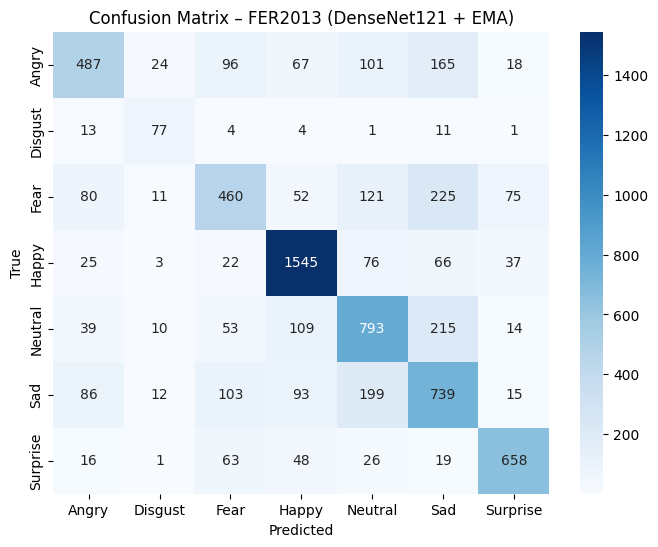

⚠️ Training history file not found. Skipping Accuracy vs Epochs plot.


In [ ]:
# ===============================================================
# ✅ FER2013 Evaluation & Analysis – DenseNet121 + EMA
# ===============================================================

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, io, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import numpy as np
import pickle  # for saving/loading training history
import os

# ===============================================================
# ✅ Model Definition
# ===============================================================
class EmotionDenseNet(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super().__init__()
        base = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        in_features = base.classifier.in_features
        base.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )
        self.model = base

    def forward(self, x):
        return self.model(x)

# ===============================================================
# ✅ Dataset for evaluation
# ===============================================================
class FERDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, categories, transform=None):
        self.data, self.labels = [], []
        self.transform = transform
        self.categories = categories
        for i, cls in enumerate(categories):
            folder = os.path.join(root_dir, cls)
            file_list = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]
            for fn in file_list:
                fp = os.path.join(folder, fn)
                img = io.read_image(fp)
                if img.shape[0] == 1:
                    img = img.repeat(3,1,1)
                self.data.append(img)
                self.labels.append(i)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx].float() / 255.0
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# ===============================================================
# ✅ Device
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# ===============================================================
# ✅ Load EMA Model
# ===============================================================
model_path = "/content/drive/MyDrive/AI_P/fer_densenet121_final.pth"
model = EmotionDenseNet(num_classes=7)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ===============================================================
# ✅ Load Test Dataset
# ===============================================================
categories = ['angry','disgust','fear', 'happy', 'neutral', 'sad', 'surprise']
test_root = "/content/drive/MyDrive/AI_P/archive (2)/test"

transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_dataset = FERDataset(test_root, categories, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ===============================================================
# ✅ Evaluate Model
# ===============================================================
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, lbls in tqdm(test_loader, desc="Evaluating"):
        imgs, lbls = imgs.to(device), lbls.to(device)
        outs = model(imgs)
        preds = outs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[
    'Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise'
]))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise'],
            yticklabels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise'])
plt.title('Confusion Matrix – FER2013 (DenseNet121 + EMA)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ===============================================================
# ✅ Accuracy vs Epochs Plot
# ===============================================================
# If you saved history during training:
# Example format: history = {'train_acc': [...], 'val_acc': [...], 'train_loss': [...], 'val_loss': [...]}
history_path = "/content/drive/MyDrive/AI_P/fer_training_history.pkl"

if os.path.exists(history_path):
    with open(history_path, "rb") as f:
        history = pickle.load(f)

    epochs = len(history['train_acc'])
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), history['train_acc'], label="Train Accuracy")
    plt.plot(range(1, epochs+1), history['val_acc'], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ Training history file not found. Skipping Accuracy vs Epochs plot.")

# ===============================================================
# ✅ Inference on Single Image (Optional)
# ===============================================================
def predict_emotion(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((48,48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(1).item()
    return categories[pred]

# Example:
# print("Predicted emotion:", predict_emotion("/content/sample_image.jpg"))


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#!cp /kaggle/working/fer2013_densenet121_weighted_ema_warmup.pth /content/drive/MyDrive/
